In [17]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

import random

# Set the seed
random.seed(19)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
data = pd.read_csv("/content/drive/My Drive/DataThesis/BETN073/data8-18.csv")

In [19]:
data

,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_fut1,...,day_lag30,day_lag365,day_fut365,IsHoliday,Season,sin_date,cos_date,Day_of_Week_Sin,Day_of_Week_Cos,nrr95p
0,2008,1,1,18.5000,2,0,18.735539,4.8750,44.1250,46.1250,...,54.468350,71.2500,12.3750,1,1,2.012985e-01,0.979530,0.974928,-0.222521,0.024135
1,2008,1,2,46.1250,3,0,25.046348,18.5000,24.3750,38.2500,...,56.441998,52.6250,5.0000,0,1,3.943559e-01,0.918958,0.433884,-0.900969,0.000000
2,2008,1,3,38.2500,4,0,39.475715,46.1250,39.8750,33.1250,...,56.783627,53.2500,8.6250,0,1,5.712682e-01,0.820763,-0.433884,-0.900969,0.098419
3,2008,1,4,33.1250,5,0,36.636801,38.2500,46.7500,68.2500,...,55.493237,54.0000,17.3750,0,1,7.247928e-01,0.688967,-0.974928,-0.222521,0.061696
4,2008,1,5,68.2500,6,1,38.360714,33.1250,62.1250,57.1250,...,52.570829,53.2500,26.7500,0,1,8.486443e-01,0.528964,-0.781831,0.623490,1.034282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,2018,12,27,13.4375,4,0,26.093061,7.0625,64.1875,7.0625,...,19.250000,54.0625,45.2500,0,1,-7.247928e-01,0.688967,-0.433884,-0.900969,0.000000
3910,2018,12,28,7.0625,5,0,27.687675,13.4375,70.2500,28.1875,...,42.687500,49.4375,42.1250,0,1,-5.712682e-01,0.820763,-0.974928,-0.222521,0.010788
3911,2018,12,29,28.1875,6,1,21.953679,7.0625,69.4375,30.8125,...,49.812500,52.8750,32.8750,0,1,-3.943559e-01,0.918958,-0.781831,0.623490,0.001605
3912,2018,12,30,30.8125,0,1,32.687630,28.1875,58.3750,26.3750,...,60.062500,62.4375,41.6875,0,1,-2.012985e-01,0.979530,0.000000,1.000000,0.046133


In [20]:
###Now we interpolate the missing values of day_lag1, day_lag7, day_lag30 and day_lag365
# Assuming data_a is your DataFrame
columns_to_interpolate = ['day_lag1', 'day_lag7', 'day_lag30', 'day_lag365', 'day_fut1', 'day_fut7']

# Interpolate missing values in specified columns
data[columns_to_interpolate] = data[columns_to_interpolate].interpolate(method='polynomial', order=2)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3914 entries, 0 to 3913
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             3914 non-null   int64  
 1   Month            3914 non-null   int64  
 2   Day              3914 non-null   int64  
 3   Concentration    3914 non-null   float64
 4   DayOfWeek        3914 non-null   int64  
 5   Weekend          3914 non-null   int64  
 6   FittedValues     3914 non-null   float64
 7   day_lag1         3914 non-null   float64
 8   day_lag7         3914 non-null   float64
 9   day_fut1         3914 non-null   float64
 10  day_fut7         3914 non-null   float64
 11  day_lag30        3914 non-null   float64
 12  day_lag365       3914 non-null   float64
 13  day_fut365       3914 non-null   float64
 14  IsHoliday        3914 non-null   int64  
 15  Season           3914 non-null   int64  
 16  sin_date         3914 non-null   float64
 17  cos_date      

In [22]:
# Define features (X) and target variable (y)
X = data.drop(columns=['Concentration'])
y = data[['Concentration']]

In [23]:
print(X, y)

      Year  Month  Day  DayOfWeek  Weekend  FittedValues  day_lag1  day_lag7  \
0     2008      1    1          2        0     18.735539    4.8750   44.1250   
1     2008      1    2          3        0     25.046348   18.5000   24.3750   
2     2008      1    3          4        0     39.475715   46.1250   39.8750   
3     2008      1    4          5        0     36.636801   38.2500   46.7500   
4     2008      1    5          6        1     38.360714   33.1250   62.1250   
...    ...    ...  ...        ...      ...           ...       ...       ...   
3909  2018     12   27          4        0     26.093061    7.0625   64.1875   
3910  2018     12   28          5        0     27.687675   13.4375   70.2500   
3911  2018     12   29          6        1     21.953679    7.0625   69.4375   
3912  2018     12   30          0        1     32.687630   28.1875   58.3750   
3913  2018     12   31          1        0     34.091967   30.8125   56.5000   

      day_fut1  day_fut7  day_lag30  da

In [24]:
# Step 1: Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()  # Separate scaler for the target variable

In [25]:
# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Step 4: Fit and transform the scaler on the training features and target
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

In [27]:
# Step 5: Transform the testing features and target using the fitted scaler
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [28]:
# Define the autoencoder architecture
output_dim_concentration = 1  # Concentration feature
input_dim_year = 1  # Date feature
input_dim_month = 1  # Date feature
input_dim_day = 1  # Date feature
input_dim_dayweek = 1  # Hour feature
input_dim_weekend = 1  # Date feature
input_dim_fitted = 1  # ARIMA (10,0,11) Fitted Values feature
input_dim_lag1 = 1  # 1-Day lag feature
input_dim_lag7 = 1  # 7-Day lag feature
input_dim_fut1 = 1 # 1 future val
input_dim_fut7 = 1 # 7 future val
input_dim_lag30 = 1  # 30-Day lag feature
input_dim_lag365 = 1  # 365-Day lag feature
input_dim_fut365 = 1 # 365 future val
input_dim_holiday = 1  # Date feature
input_dim_season = 1  # Date feature
input_dim_datesin = 1 # Sin Date feature
input_dim_datecos = 1 # Cos Date feature
input_dim_dowsin = 1 # Sin Day of Week feature
input_dim_dowcos = 1 # Cos Day of Week feature
input_dim_prep = 1 # Precipitation feature


encoding_dim = 1  # Adjust the size of the encoded representation as needed

output_concentration = Input(shape=(output_dim_concentration,))
input_year = Input(shape=(input_dim_year,))
input_month = Input(shape=(input_dim_month,))
input_day = Input(shape=(input_dim_day,))
input_dayweek = Input(shape=(input_dim_dayweek,))
input_weekend = Input(shape=(input_dim_weekend,))
input_season = Input(shape=(input_dim_season,))
input_holiday = Input(shape=(input_dim_holiday,))
input_fitted = Input(shape=(input_dim_fitted,))
input_lag1 = Input(shape=(input_dim_lag1,))
input_lag7 = Input(shape=(input_dim_lag7,))
input_lag30 = Input(shape=(input_dim_lag30,))
input_lag365 = Input(shape=(input_dim_lag365,))
input_fut1 = Input(shape=(input_dim_fut1,))
input_fut7 = Input(shape=(input_dim_fut7,))
input_fut365 = Input(shape=(input_dim_fut365,))
input_datesin = Input(shape=(input_dim_datesin,))
input_datecos = Input(shape=(input_dim_datecos,))
input_dowsin = Input(shape=(input_dim_dowsin,))
input_dowcos = Input(shape=(input_dim_dowcos,))
input_prep = Input(shape=(input_dim_prep,))

# Concatenate inputs
concatenated = Concatenate()([input_year, input_month, input_day, input_dayweek, input_weekend, input_fitted, input_lag1, input_lag7, input_fut1, input_fut7, input_lag30, input_lag365, input_fut365, input_holiday, input_season, input_datesin, input_datecos, input_dowsin, input_dowcos, input_prep])

# Encoder layers
encoded = Dense(128, activation='relu')(concatenated)  # First hidden layer
encoded = Dense(64, activation='relu')(encoded)      # Second hidden layer
encoded = Dense(16, activation='relu')(encoded)      # Third hidden layer
encoded = Dense(8, activation='relu')(encoded)      # Fourth hidden layer
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Encoding layer

# Decoder layers
decoded = Dense(8, activation='relu')(encoded)      # First hidden layer in decoder
decoded = Dense(16, activation='relu')(decoded)      # Second hidden layer in decoder
decoded = Dense(64, activation='relu')(decoded)      # Third hidden layer in decoder
decoded = Dense(128, activation='relu')(decoded)      # Fourth hidden layer in decoder
decoded = Dense(1, activation='linear')(decoded)

autoencoder = Model([input_year, input_month, input_day, input_dayweek, input_weekend, input_fitted, input_lag1, input_lag7, input_fut1, input_fut7, input_lag30, input_lag365, input_fut365, input_holiday, input_season, input_datesin, input_datecos, input_dowsin, input_dowcos, input_prep], decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder using only observed data
autoencoder.fit([X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2], X_train_scaled[:, 3], X_train_scaled[:, 4], X_train_scaled[:, 5],
                 X_train_scaled[:, 6], X_train_scaled[:, 7], X_train_scaled[:, 8], X_train_scaled[:, 9], X_train_scaled[:, 10],
                 X_train_scaled[:, 11], X_train_scaled[:, 12], X_train_scaled[:, 13], X_train_scaled[:, 14], X_train_scaled[:, 15], X_train_scaled[:, 16],
                 X_train_scaled[:, 17], X_train_scaled[:, 18], X_train_scaled[:, 19]], y_train_scaled[:, 0], epochs=10, batch_size=63, shuffle=True, validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 2s 11ms/step - loss: 0.0327 - val_loss: 0.0136
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 3/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 4/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 5/10
40/40 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 0.0061 - val_loss: 0.0072
Epoch 7/10
40/40 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 8/10
40/40 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 9/10
40/40 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 10/10
40/40 [==============================] - 0s 8ms/step - loss: 0.0061 - val_loss: 0.0068


In [29]:
# Step 8: After making predictions, inverse transform the predictions
predictions_scaled = autoencoder.predict([X_test_scaled[:, 0], X_test_scaled[:, 1], X_test_scaled[:, 2], X_test_scaled[:, 3], X_test_scaled[:, 4], X_test_scaled[:, 5],
                 X_test_scaled[:, 6], X_test_scaled[:, 7], X_test_scaled[:, 8], X_test_scaled[:, 9], X_test_scaled[:, 10],
                 X_test_scaled[:, 11], X_test_scaled[:, 12], X_test_scaled[:, 13], X_test_scaled[:, 14], X_test_scaled[:, 15], X_test_scaled[:, 16],
                 X_test_scaled[:, 17], X_test_scaled[:, 18], X_test_scaled[:, 19]])
predictions_original_scale = scaler_y.inverse_transform(predictions_scaled)

25/25 [==============================] - 0s 3ms/step


In [30]:
# Step 9: Calculate the MSE
mse = mean_squared_error(y_test, predictions_original_scale)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Step 10: Calculate the MAE
mae = mean_absolute_error(y_test, predictions_original_scale)
print(f'Mean Absolute Error (MAE): {mae:.2f}')


Mean Squared Error (MSE): 218.60
Mean Absolute Error (MAE): 11.45


# Graph

In [31]:
y_test = y_test.reset_index()
y_test = y_test.drop(columns='index')

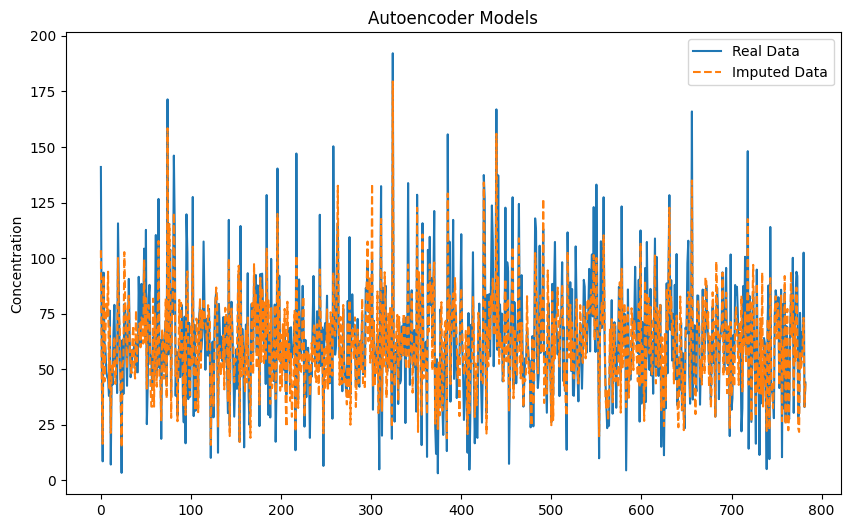

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(y_test['Concentration'], label='Real Data')
plt.plot(predictions_original_scale, label='Imputed Data', linestyle='dashed')
plt.title('Autoencoder Models')
plt.ylabel('Concentration')
plt.legend()
plt.show()